# Summarize Runs
Find the best model

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import json

## Gather outputs from runs
Get the configuration and test summary

In [2]:
complete_runs = [x.parent for x in Path('runs').glob('*/test_summary.json')]
print(f'Found {len(complete_runs)} completed runs')

Found 15 completed runs


In [3]:
def load_summary(path: Path) -> dict:
    """Load the summary of the run configuration and parameters
    
    Args:
        path: Path to the run
    Returns:
        Summary of inputs and results
    """
    
    output = {'path': path}
    output.update(json.loads((path / 'config.json').read_text()))
    output.update(json.loads((path / 'test_summary.json').read_text()))
    return output

In [4]:
summary = pd.DataFrame(map(load_summary, complete_runs)).sort_values('force_rmse')
summary.head()

,path,num_interactions,num_features,num_gaussians,cutoff,train_size,huber_deltas,num_epochs,batch_size,learning_rate,lr_patience,energy_weight,method,test_runtime,energy_mae,force_rmse
2,runs/N3000000-n32-b68e4767,4,256,32,6.0,3000000,"[0.1, 1]",32,32,0.0001,2,0.1,wb97x_dz,330.984364,0.003589,0.171181
0,runs/N1000000-n32-8127e7dd,4,256,32,6.0,1000000,"[0.1, 1]",32,32,0.0001,2,0.1,wb97x_dz,328.641480,0.006669,0.247041
7,runs/N300000-n64-cc87a1ab,4,256,32,6.0,300000,"[0.1, 1]",64,32,0.0001,2,0.1,wb97x_dz,326.829402,0.013233,0.370472
9,runs/N100000-n64-c1454923,4,256,32,6.0,100000,"[0.1, 1]",64,32,0.0001,2,0.1,wb97x_dz,325.600258,0.014859,0.400227
14,runs/N30000-n64-e343abfb,4,512,32,6.0,30000,"[0.1, 1]",64,32,0.0001,2,0.1,wb97x_dz,417.616412,0.027689,0.463388


## Converge different run parameters
We are doing our HPO with a training set size of 30000.

First up is the number of features to represent each atom

In [5]:
cutoff_subset = summary.query('train_size == 30000 and cutoff==6.0 and num_gaussians==32 and num_interactions==4').sort_values('num_features')

Text(0, 0.5, 'Force, RMSD (eV/$\\AA$)')

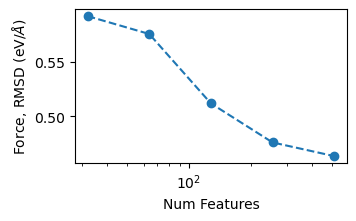

In [6]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.semilogx(cutoff_subset['num_features'], cutoff_subset['force_rmse'], '--o')

ax.set_xlabel('Num Features')
ax.set_ylabel('Force, RMSD (eV/$\\AA$)')

It looks like 256 is sufficient. Gains at 512 are margin for the large increase in computational cost.

In [7]:
subset = summary.query('train_size == 30000 and cutoff==6.0 and num_features==256 and num_interactions==4').sort_values('num_gaussians')

Text(0, 0.5, 'Force, RMSD (eV/$\\AA$)')

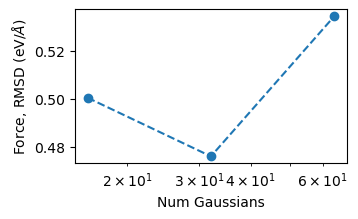

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.semilogx(subset['num_gaussians'], subset['force_rmse'], '--o')

ax.set_xlabel('Num Gaussians')
ax.set_ylabel('Force, RMSD (eV/$\\AA$)')

Our first guess of 32 seems right. 

In [9]:
subset = summary.query('train_size == 30000 and cutoff==6.0 and num_features==256 and num_gaussians==32').sort_values('num_interactions')

Text(0, 0.5, 'Force, RMSD (eV/$\\AA$)')

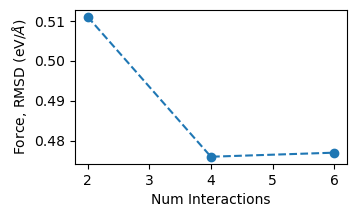

In [10]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.plot(subset['num_interactions'], subset['force_rmse'], '--o')

ax.set_xlabel('Num Interactions')
ax.set_ylabel('Force, RMSD (eV/$\\AA$)')

Looks like 4 interactions is enough.

## Training Set Size
Make sure the network is still learning as we add more training data.

In [11]:
subset = summary.query('cutoff==6.0 and num_features==256 and num_gaussians==32 and num_interactions == 4').sort_values('train_size')

Text(0, 0.5, 'Force, RMSD (eV/$\\AA$)')

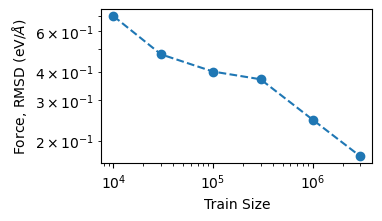

In [12]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.loglog(subset['train_size'], subset['force_rmse'], '--o')

ax.set_xlabel('Train Size')
ax.set_ylabel('Force, RMSD (eV/$\\AA$)')

There is not yet a diminishing return with more data. That's a good place to be in.

## Learning Curve
Figure out if we've completly converged wrt to number of epochs

In [13]:
best = summary.sort_values('force_rmse').iloc[0]

In [14]:
log = pd.read_csv(best.path / 'log.csv')
#log = pd.read_csv('runs/N1000000-n32-8127e7dd/log.csv')

Text(0, 0.5, 'Loss')

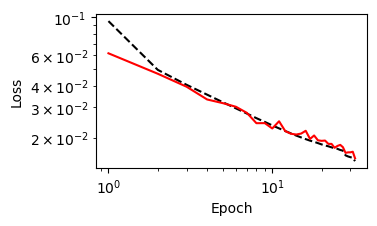

In [15]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.loglog(log['epoch'] + 1, log['train_loss_total'], '--k')
ax.loglog(log['epoch'] + 1, log['valid_loss_total'], '-r')


ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

We don't finish converging even past 32 epochs. Need to set up a longer run

## Plot the Learning Data
Get an idea of what level of errors to expect

In [16]:
test_data = pd.read_csv(best.path / 'test_records.csv.gz')
print(f'Loaded {len(test_data)} test records')

Loaded 596714 test records


Show the predicted vs actual

In [17]:
true_forces = np.concatenate(test_data['force_true'].apply(json.loads).apply(np.ravel))

In [18]:
ml_forces = np.concatenate(test_data['force_ml'].apply(json.loads).apply(np.ravel))

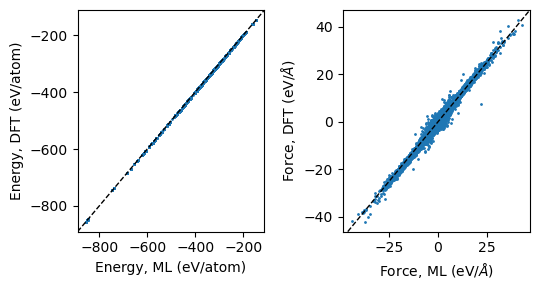

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(5.5, 3.))

# Energy plot
axs[0].scatter(test_data['energy_ml'] / test_data['n_atoms'],
               test_data['energy_true'] / test_data['n_atoms'], s=1)
axs[0].set_xlabel('Energy, ML (eV/atom)')
axs[0].set_ylabel('Energy, DFT (eV/atom)')

# Force plot
axs[1].scatter(ml_forces, true_forces, s=1)
axs[1].set_xlabel('Force, ML (eV/$\\AA$)')
axs[1].set_ylabel('Force, DFT (eV/$\\AA$)')

for ax in axs:
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--', lw=1)

fig.tight_layout()

## Save path to best model
Get the model location 

In [20]:
best_path = Path('best_model')
if best_path.exists():
    best_path.unlink()

In [21]:
best_path.symlink_to(best.path)